# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# TSNE

## Negative square distance
$ -||x_i - x_j ||^2 $

In [2]:
def neg_squared_euc_dists(X):
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    return -D


## Joint Probability distribution matrix Q
$ q_{i, j} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\Sigma_{k\neq l}(1+||y_k-y_l||^2)^{-1}} $

In [3]:
def q_tsne(Y):
    distances = neg_squared_euc_dists(Y)
    inv_distances = np.power(1. - distances, -1)
    np.fill_diagonal(inv_distances, 0.)
    return inv_distances / np.sum(inv_distances), inv_distances

## TSNE Gradient function
$ \frac{\partial C}{\partial y_i} = 4\Sigma_{j} (p_{i, j} - q_{i, j})(y_i - y_j)(1 + ||y_i-y_j||^2)^{-1}$

In [4]:
def tsne_grad(P, Q, Y, inv_distances):
    pq_diff = P - Q
    pq_expanded = np.expand_dims(pq_diff, 2)
    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    distances_expanded = np.expand_dims(inv_distances, 2)
    y_diffs_wt = y_diffs * distances_expanded
    grad = 4. * (pq_expanded * y_diffs_wt).sum(1)
    return grad


## Softmax
$ X_{i} = \frac{exp(X_{i})}{\Sigma_{j}(exp(X_j))}$

In [5]:
def softmax(X, diag_zero=True, zero_index=None):
    e_x = np.exp(X - np.max(X, axis=1).reshape([-1, 1]))
    if zero_index is None:
        if diag_zero:
            np.fill_diagonal(e_x, 0.)
    else:
        e_x[:, zero_index] = 0.
    e_x = e_x + 1e-8  # numerical stability
    return e_x / e_x.sum(axis=1).reshape([-1, 1])


## Utilities

In [6]:
def calc_prob_matrix(distances, sigmas=None, zero_index=None):
    if sigmas is not None:
        two_sig_sq = 2. * np.square(sigmas.reshape((-1, 1)))
        return softmax(distances / two_sig_sq, zero_index=zero_index)
    else:
        return softmax(distances, zero_index=zero_index)


def binary_search(eval_fn, target, tol=1e-10, max_iter=10000,
                  lower=1e-20, upper=1000.):
    for i in range(max_iter):
        guess = (lower + upper) / 2.
        val = eval_fn(guess)
        if val > target:
            upper = guess
        else:
            lower = guess
        if np.abs(val - target) <= tol:
            break
    return guess


## Perplexity
$ H(P_i) = -\Sigma_{i}p_{j|i}\log(p_{j|i}) $

$ Perp(P_i) = 2^{H(P_i)} $

In [7]:
def calc_perplexity(prob_matrix):
    entropy = -np.sum(prob_matrix * np.log2(prob_matrix), 1)
    perplexity = 2 ** entropy
    return perplexity

def perplexity(distances, sigmas, zero_index):
    return calc_perplexity(
        calc_prob_matrix(distances, sigmas, zero_index))


## Find sigma matrix

In [8]:
def find_optimal_sigmas(distances, target_perplexity):
    sigmas = []
    for i in range(distances.shape[0]):
        eval_fn = lambda sigma: \
            perplexity(distances[i:i+1, :], np.array(sigma), i)
        correct_sigma = binary_search(eval_fn, target_perplexity)
        sigmas.append(correct_sigma)
    return np.array(sigmas)


## Calculate the P Matrices

In [9]:
def p_conditional_to_joint(P):
    return (P + P.T) / (2. * P.shape[0])

In [10]:
def p_joint(X, target_perplexity):
    distances = neg_squared_euc_dists(X)
    sigmas = find_optimal_sigmas(distances, target_perplexity)
    p_conditional = calc_prob_matrix(distances, sigmas)
    P = p_conditional_to_joint(p_conditional)
    return P


## Plotter

In [11]:
def categorical_scatter_2d(X2D, class_idxs, ms=3, ax=None, alpha=0.1, 
                           legend=True, figsize=None, show=False, 
                           savename=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    classes = list(np.unique(class_idxs))
    markers = 'os' * len(classes)
    colors = plt.cm.rainbow(np.linspace(0,1,len(classes)))

    for i, cls in enumerate(classes):
        mark = markers[i]
        ax.plot(X2D[class_idxs==cls, 0], X2D[class_idxs==cls, 1], marker=mark, 
            linestyle='', ms=ms, label=str(cls), alpha=alpha, color=colors[i],
            markeredgecolor='black', markeredgewidth=0.4)
    if legend:
        ax.legend()
        
    if savename is not None:
        plt.tight_layout()
        plt.savefig(savename)
    
    if show:
        plt.show()
    
    return ax


## Global variables

In [12]:
# Set global parameters
CLASSES_TO_USE = [i for i in range(10)]  # MNIST classes to use
PERPLEXITY = 20
SEED = 1                    # Random seed
MOMENTUM = 0.9
LEARNING_RATE = 10.
NUM_ITERS = 500             # Num iterations to train for
NUM_PLOTS = 5               # Num. times to plot in training

## Main TSNE function

In [13]:
def estimate_sne(X, y, P, rng, num_iters, learning_rate, momentum, plot):
    Y = rng.normal(0., 0.0001, [X.shape[0], 2])
  
    if momentum:
        Y_m2 = Y.copy()
        Y_m1 = Y.copy()
  
    for i in range(num_iters):
        Q, distances = q_tsne(Y)
        grads = tsne_grad(P, Q, Y, distances)
        Y = Y - learning_rate * grads
        if momentum:
            Y += momentum * (Y_m1 - Y_m2)
            Y_m2 = Y_m1.copy()
            Y_m1 = Y.copy()

        if plot and i % (num_iters / plot) == 0:
            categorical_scatter_2d(Y, y, alpha=1.0, ms=6,
                                   show=True, figsize=(9, 6))

    return Y


In [14]:
def get_TSNE_output_and_plot(X, y):
    P = p_joint(X, PERPLEXITY)
    Y = estimate_sne(X, y, P, rng,
            num_iters=NUM_ITERS,
            learning_rate=LEARNING_RATE,
            momentum=MOMENTUM,
            plot=NUM_PLOTS)
    return Y

# MNIST

In [15]:
!pip3 install python-mnist

In [16]:
def load_mnist():
    from mnist.loader import MNIST
    mndata = MNIST('/home/kunal.jain/t-SNE/samples')
    trainImage, trainLables = mndata.load_training()
    return trainImage, trainLables

In [17]:
rng = np.random.RandomState(SEED)

X_all, y_all = load_mnist()
X_all = np.array(X_all)
y_all = np.array(y_all)
print(X_all.shape)
print(y_all.shape)


(60000, 784)
(60000,)


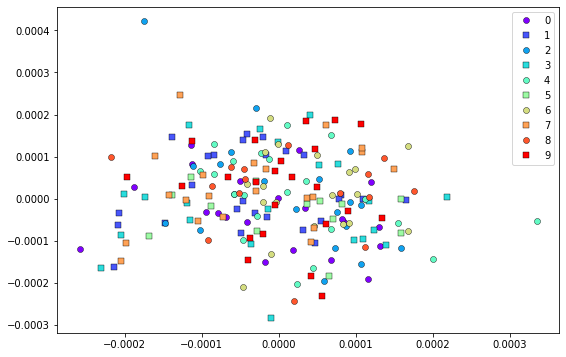

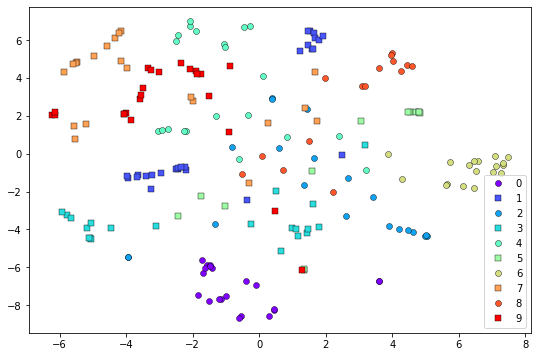

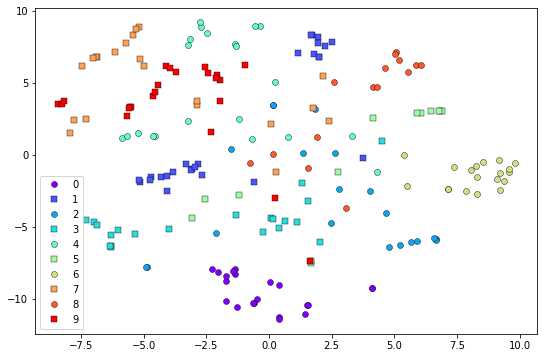

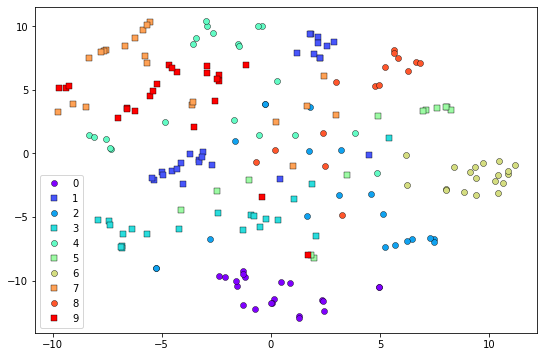

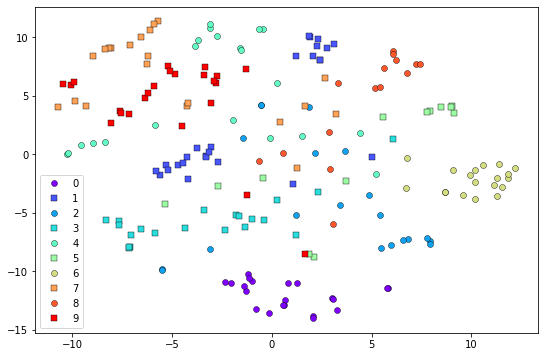

In [19]:
NUM_POINTS = 200
X = X_all[0:NUM_POINTS]
y = y_all[0:NUM_POINTS]
Y = get_TSNE_output_and_plot(X, y)

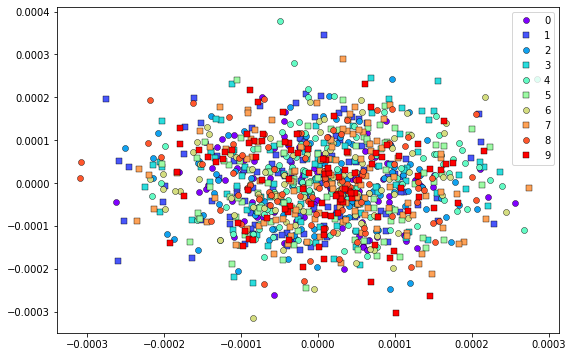

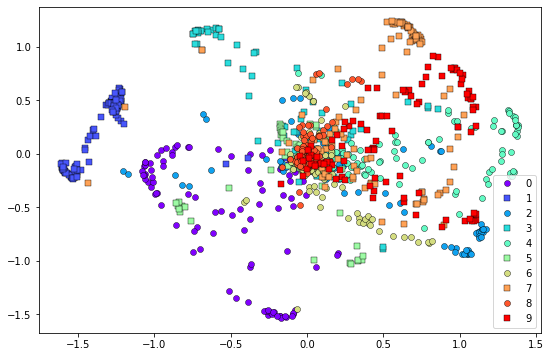

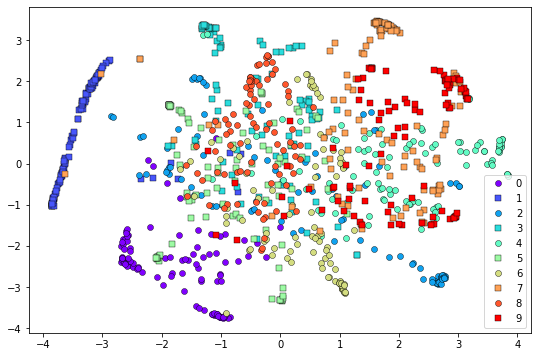

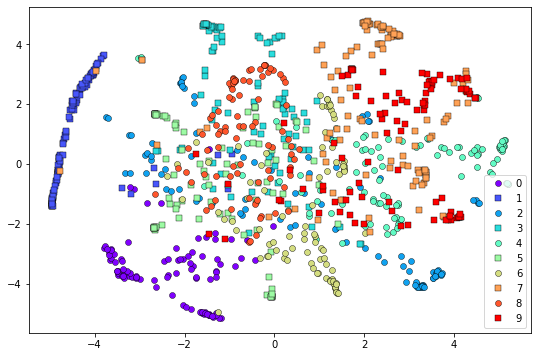

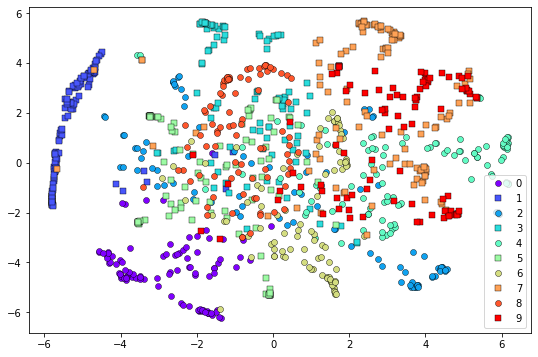

In [20]:
NUM_POINTS = 1000
X = X_all[0:NUM_POINTS]
y = y_all[0:NUM_POINTS]
Y = get_TSNE_output_and_plot(X, y)

In [ ]:
NUM_POINTS = 3000
X = X_all[0:NUM_POINTS]
y = y_all[0:NUM_POINTS]
Y = get_TSNE_output_and_plot(X, y)

# Olivetti faces

In [22]:
from sklearn import datasets
datasetOlivetti = datasets.fetch_olivetti_faces()

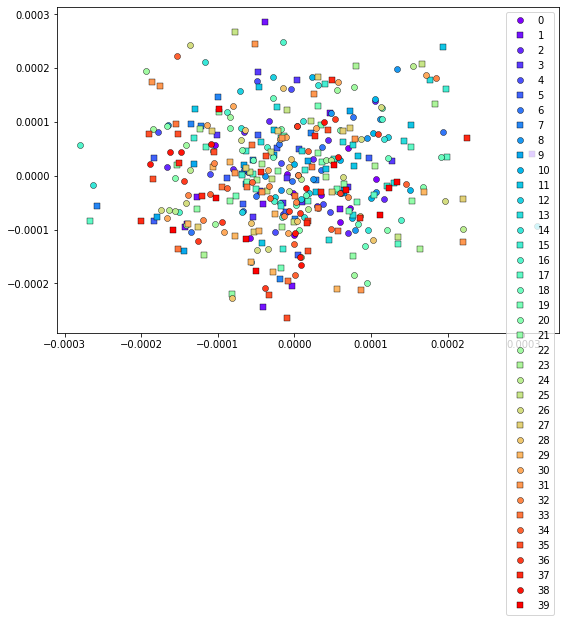

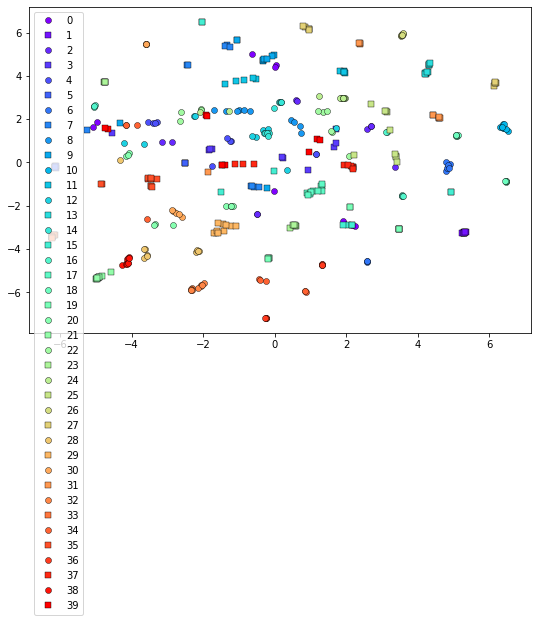

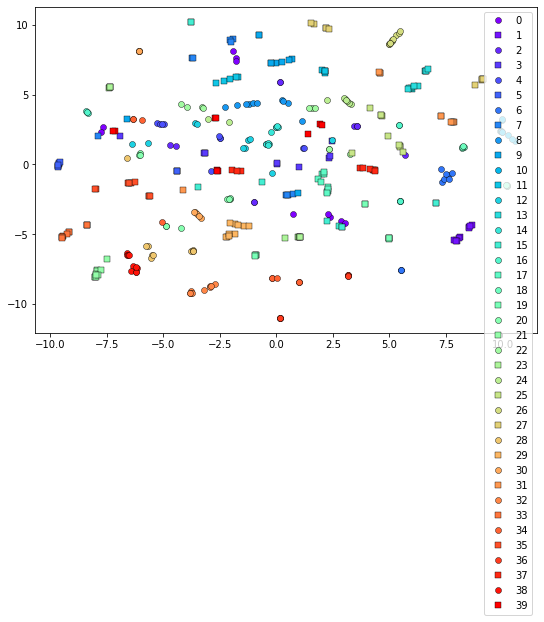

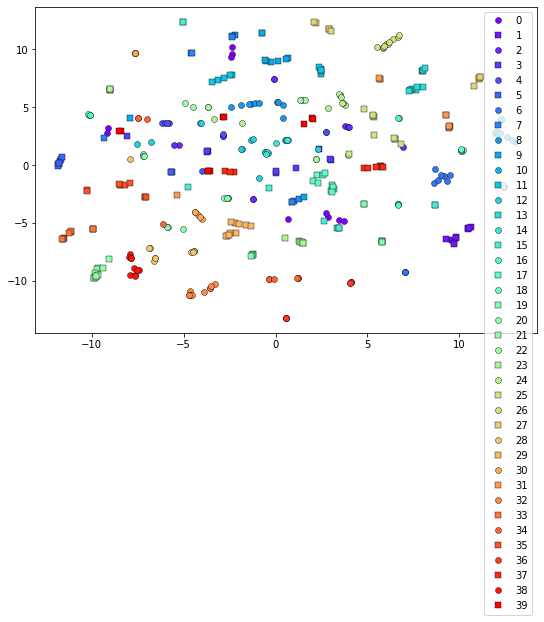

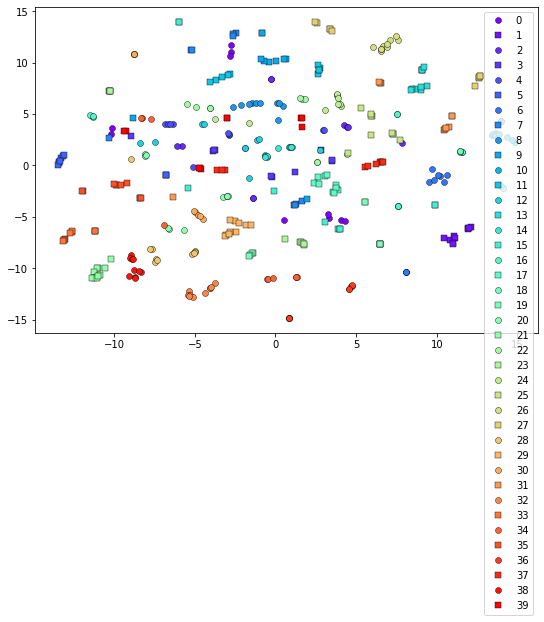

In [26]:
X = datasetOlivetti["data"]
y = datasetOlivetti["target"]
Y = get_TSNE_output_and_plot(X, y)